In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pandas as pd
from speech_study.path_conf import loc_data_dir
import skimage
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math

## Playground

In [3]:
img = skimage.io.imread(list(loc_data_dir.joinpath("FeedbackBars").glob("*.PNG"))[0])

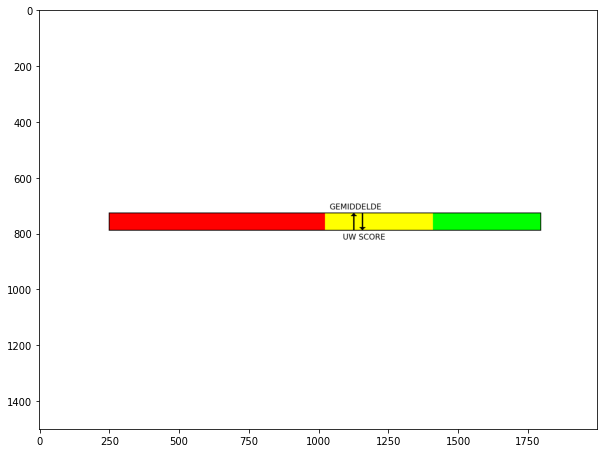

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(img)

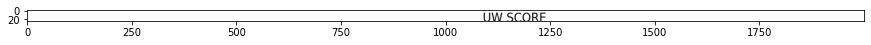

In [15]:
# This y-range is the bottom of the feedback bar displaying the "UW SCORE" value
plt.figure(figsize=(15, 3))
plt.imshow(img[795:820, :, :])

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate the sum ofter the y-axis for the feedback bar
y = np.sum(np.sum(img[795:820, :, :], axis=2)*-1, axis=0)
f = make_subplots(rows=2, cols=1, shared_xaxes=True)

f.add_trace(go.Image(z=img[795:820, :, :]), row=2, col=1)
f.add_trace(go.Scatter(y=y), row=1, col=1)

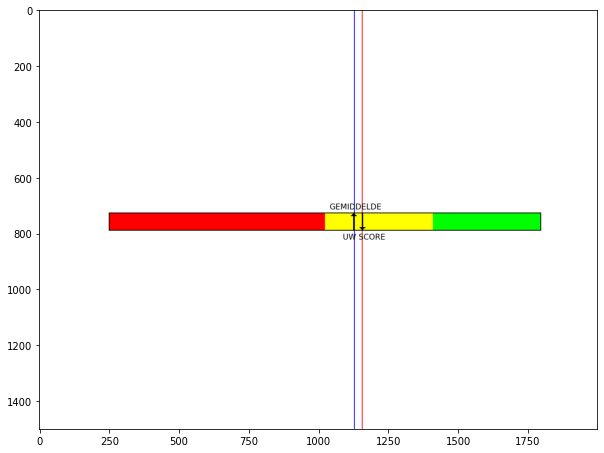

In [37]:
img_cp = img.copy()

fig = plt.figure(figsize=(10, 10))
# Use the find_peaks to find the exact line positions of the "UW SCORE" and "GEMIDDELDE"
score_ref = find_peaks(np.sum(np.sum(img[790:825, :, :], axis=2), axis=0))[0][0] + 60
avg_ref = find_peaks(np.sum(np.sum(img[685:715, :, :], axis=2), axis=0))[0][0] + 77
img_cp[:, score_ref -1: score_ref +2, 1:3] = 0
img_cp[:, avg_ref -1: avg_ref +2, 0:2] = 0
plt.imshow(img_cp, )

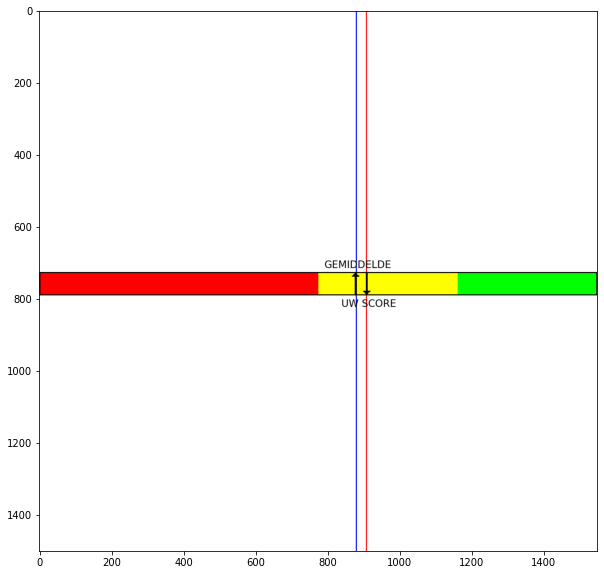

In [38]:
# Check whether we know what the feedback its x-boundaries are 
# This is needed to convert these the detected positions into percentages
plt.figure(figsize=(10, 10))
plt.imshow(img_cp[:, 249:1799, ])

## Processing the feedbackbars

In [39]:
pngs = list(loc_data_dir.joinpath("FeedbackBars").glob("*.PNG"))

n_cols = 4
_, axs = plt.subplots(
    nrows=math.ceil(len(pngs) / n_cols), ncols=n_cols, 
    figsize=(60, 300)
)

# Variable in which all feedback position data will be stored
data_dict = {"png_name": [], "avg": [], "ur_score": []}
start = 250  # The start of the feedback bar
end = 1799  # The end of the feedback bar

for i, png in tqdm(enumerate(pngs)):
    img = skimage.io.imread(png)

    sc_pos = find_peaks(np.sum(np.sum(img[790:825, :, :], axis=2), axis=0))[0][0] + 60
    avg_pos = find_peaks(np.sum(np.sum(img[685:715, :, :], axis=2), axis=0))[0][0] + 77

    img_ = img.copy()
    img_[:, avg_pos - 2 : avg_pos + 2, :2] = 0
    img_[:, sc_pos - 2 : sc_pos + 2, 1:3] = 0

    axs[i // n_cols, i % n_cols].imshow(img_)
    axs[i // n_cols, i % n_cols].axis("off")
    axs[i // n_cols, i % n_cols].set_title(png.name.split(".")[0])

    data_dict["png_name"].append(png.name.split(".")[0])
    data_dict["avg"].append(avg_pos)
    data_dict['ur_score'].append(sc_pos)

0it [00:00, ?it/s]

In [40]:
# Convert data-dict into a dataframe and parse it
df_feedback = pd.DataFrame(data_dict)
df_feedback["avg"] = (df_feedback["avg"] - start) / (end - start)
df_feedback["ur_score"] = (df_feedback["ur_score"] - start) / (end - start)

df_feedback[
    ["condition", "sub_block", "trial", "answer_type"]
] = df_feedback.png_name.map(
    lambda s: [s[0], int(s[1]), int(s.split("_")[1]), s.split("_")[-1]]
).tolist()

df_feedback["condition"] = df_feedback.condition.map(
    lambda x: {"C": "control", "S": "negative"}.get(x)
)
df_feedback


png_name       avg  ur_score condition sub_block trial answer_type
0       C2_2_fout  0.568108  0.586185   control         2     2        fout
1       S1_3_fout  0.716591  0.603615  negative         1     3        fout
2    C2_9_correct  0.736604  0.848289   control         2     9     correct
3    C3_2_correct  0.714655  0.805681   control         3     2     correct
4    S3_7_correct  0.669464  0.548741  negative         3     7     correct
..            ...       ...       ...       ...       ...   ...         ...
127  C1_9_correct  0.741769  0.772757   control         1     9     correct
128  S1_4_correct  0.710781  0.581666  negative         1     4     correct
129     S3_9_fout  0.673983  0.346030  negative         3     9        fout
130  C3_9_correct  0.740478  0.830859   control         3     9     correct
131  C2_7_correct  0.739187  0.832150   control         2     7     correct

[132 rows x 7 columns]

In [41]:
df_feedback.to_csv(loc_data_dir.joinpath('slider_feedback.csv'), index=None)

## Data visualization

In [45]:
df_feedback = pd.read_csv(loc_data_dir.joinpath('slider_feedback.csv'))

In [46]:
import seaborn as sns
sns.set_context('talk')

In [47]:
df_feedback

png_name       avg  ur_score condition  sub_block  trial answer_type
0       C2_2_fout  0.568108  0.586185   control          2      2        fout
1       S1_3_fout  0.716591  0.603615  negative          1      3        fout
2    C2_9_correct  0.736604  0.848289   control          2      9     correct
3    C3_2_correct  0.714655  0.805681   control          3      2     correct
4    S3_7_correct  0.669464  0.548741  negative          3      7     correct
..            ...       ...       ...       ...        ...    ...         ...
127  C1_9_correct  0.741769  0.772757   control          1      9     correct
128  S1_4_correct  0.710781  0.581666  negative          1      4     correct
129     S3_9_fout  0.673983  0.346030  negative          3      9        fout
130  C3_9_correct  0.740478  0.830859   control          3      9     correct
131  C2_7_correct  0.739187  0.832150   control          2      7     correct

[132 rows x 7 columns]

In [48]:
# each block can contain 12 trials  
df_feedback['trial'] += (df_feedback['sub_block'] -1)*11

rename_dict = {'avg': 'mean of reference group', 'ur_score': 'your score'}
df_feedback = df_feedback.rename(columns=rename_dict)

df_feedback[list(rename_dict.values())] *= 100  # convert to percentages

answer_mapping = {'fout': 'incorrect'}
df_feedback['answer_type'] = df_feedback.answer_type.map(lambda x: answer_mapping.get(x, x))


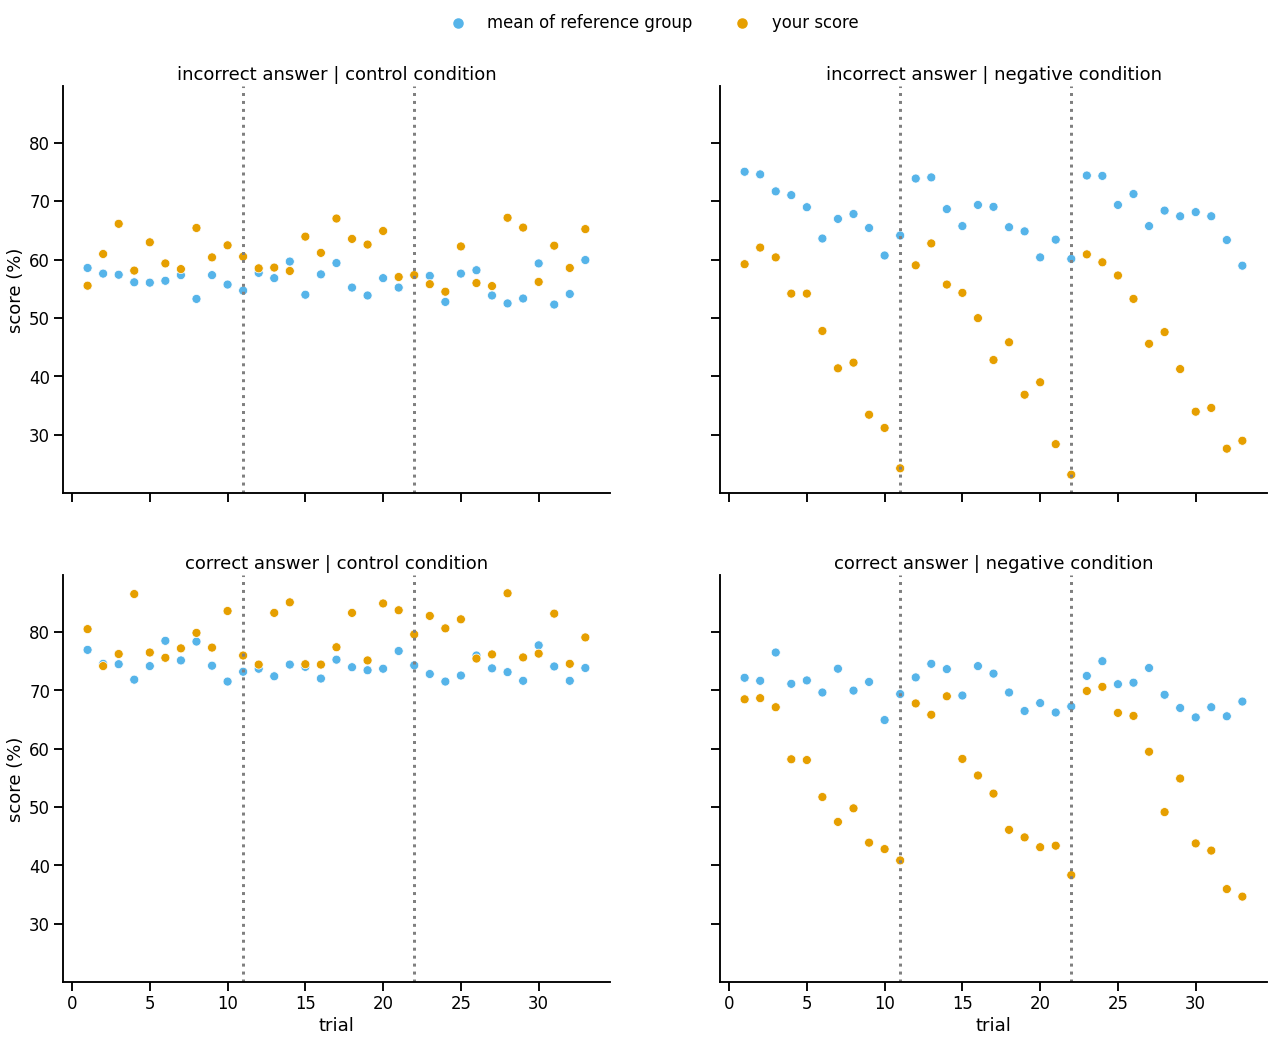

In [49]:
g = sns.relplot(
    data=df_feedback.melt(
    id_vars=['condition', 'sub_block', 'trial', 'answer_type'],
    value_vars=list(rename_dict.values()),
    value_name='score (%)'
),
    kind='scatter',
    x='trial',
    y='score (%)',
    hue='variable',
    col='condition',
    row='answer_type',
    # palette='Set2',
    palette=["#56B4E9", "#E69F00"],
    height=7,
    aspect=1.3,
)

g.set_titles("{row_name} answer | {col_name} condition")

sns.move_legend(
    g,
    "lower center",
    bbox_to_anchor=(0.43, 1),
    ncol=2,
    title="",
    frameon=False,
)


for ax in g.fig.axes:
    for x in [11, 22]:
        ax.axvline(x=x, color="grey", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.2, hspace=0.2)